# CapitalOne Data Challenge - Modeling

**I removed duplicates in a previous step (data processing) and imported the processed data by using pandas package.**

In [1]:
#load package
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score,confusion_matrix # Timestamp Data Import# Timestamp Data Import

In [9]:
credit_transactions=pd.read_csv('~/Desktop/clean_data.csv') # import data

In [10]:
credit_transactions.shape # dimension of processed data

(730174, 16)

In [11]:
credit_transactions.head(3) # quickly check the dataframe

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp,creditLimit,availableMoney,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,100088067,1st BBQ,200.12,PURCHASE,T541917,2016-04-08 19:56:36,50000,49953.81,US,9.0,1.0,food,46.19,True,False,False
1,100088067,1st Pub,95.11,PURCHASE,T541962,2016-11-09 07:26:06,50000,49929.31,US,2.0,1.0,food,70.69,True,False,False
2,100088067,1st Sandwitch Bar #758805,5.26,PURCHASE,T541920,2016-05-06 02:54:01,50000,49996.04,US,2.0,1.0,food,3.96,True,False,False


-------

# Exploration

**I explored the distribution of transaction amounts across fraud vs non-fraud cases. It shows that median of fraudulent transactions is slightly higher than median of non-fraud transactions. When creating a categorical variable (high vs low), I defined threshold as $250.**

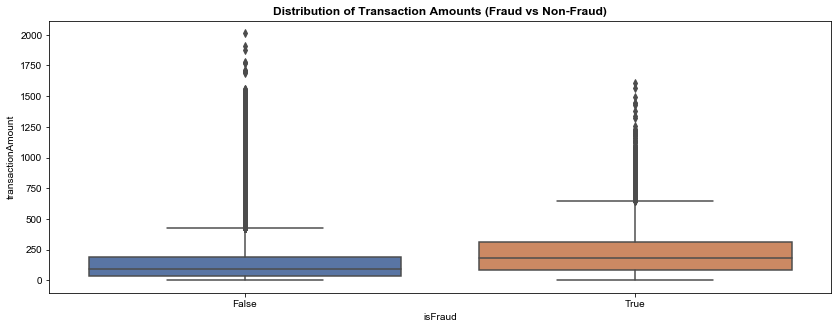

In [12]:
plt.figure(figsize=(14,5))
plt.title('Distribution of Transaction Amounts (Fraud vs Non-Fraud)',weight='bold')
sns.set()
sns.boxplot(x='isFraud', y='transactionAmount', data=credit_transactions)

------

# Sampling

**I applied under-sampling technique by applying stratified clustering approach to reduce dimensionality. In the dataset, there are 2040 customers who faced fraudulent cases. I firstly took all fraud observations from 2040 customers. Then, I took a sample (ratio=0.08) from non-fraud observations of the same customers. Lastly, I took a sample from customer who did not encounter any fraud cases in year 2016 to add noise.**

In [13]:
df_minor=credit_transactions[credit_transactions.isFraud==True] # take only fraud observations

In [14]:
len(df_minor) # There are 11710 fraud cases in the dataset

11710

In [15]:
df_minor.customerId.nunique() # 2040 unique customer have encountered fraudulent cases.

2040

In [16]:
df_minor=df_minor.reset_index(drop=True) # reset index

In [17]:
cust_list=df_minor.customerId.unique() # take a uniuq list of customers
df_new_fraud=credit_transactions[credit_transactions.customerId.isin(cust_list)] # take non-fraud cases of 2040 customers
df_new_fraud=df_new_fraud[df_new_fraud.isFraud==False] # remove fraud cases

In [18]:
df_major_1=df_new_fraud.sample(frac=0.08,random_state=42) # take an sample from the dataset

In [19]:
df_major_1=df_major_1.reset_index(drop=True) # reset index

In [20]:
df_new_2=credit_transactions[~credit_transactions.transactionKey.isin(df_major_1.transactionKey)] # take transactions which 
df_new_2=df_new_2[df_new_2.isFraud==False] # take non-fraud cases
df_major_2=df_new_2.sample(frac=0.025,random_state=42) # take an sample from the dataset

In [21]:
df_major_2=df_major_2.reset_index(drop=True) # reset index

In [22]:
df=pd.concat([df_major_1,df_major_2,df_minor],axis=0) # merge dataframes vertically
df['ID'] = df.customerId.map(str) + "-" + df.merchantName

In [23]:
df.isFraud.value_counts()

False    64085
True     11710
Name: isFraud, dtype: int64

In [24]:
round(11710/(11710+64085),4) # ratio of fraud cases to population

0.1545

In [25]:
11710+64085

75795

---

# Standardization

**I standardized transaction amounts for each customer by using their mean and stdev of transaction amounts in year 2016.**

In [33]:
# apply z-score standardization
def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    key=df_std['transactionKey']
    df_std=df_std.drop(['transactionKey'],axis=1)
    # apply the z-score method
    if len(df_std)>=2:
        for column in df_std.columns:
            df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        df_std=pd.concat([df_std,key],axis=1)
    else:
        df_std=pd.concat([df_std,key],axis=1)
        df_std.transactionAmount=0
    return df_std

In [34]:
# standardize for each customer
df_standardized={}
cst=[]
key=[]
for i in df.customerId.unique():
    sample=df[df.customerId==i][['transactionAmount','transactionKey']]
    process = z_score(sample)
    df_standardized[i]=process
    for k in range(len(sample)):
        cst.append(i)

In [35]:
nrow=len(df_standardized.keys())
df_d=pd.DataFrame()
for i in range(nrow):
    df_inter=df_standardized[[*df_standardized.keys()][i]]
    df_d=df_d.append(df_inter)
df_d=df_d.reset_index(drop=True)

In [36]:
customer=pd.DataFrame(cst)
customer.columns=['customerId']

In [37]:
combine=pd.concat([customer,df_d],axis=1)
combine.drop(['customerId'],axis=1,inplace=True)
combine.columns=['Amount_Std','transactionKey']

In [38]:
data_std=df.merge(combine,how='inner',on='transactionKey')
data_std.head(3)

,customerId,merchantName,transactionAmount,transactionType,transactionKey,Timestamp,creditLimit,availableMoney,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,ID,Amount_Std
0,432609023,South Steakhouse #879581,202.09,PURCHASE,T287662,2016-03-11 00:07:16,5000,2734.79,US,5.0,1.0,food,2265.21,True,False,False,432609023-South Steakhouse #879581,0.185984
1,245632880,amazon.com,93.57,PURCHASE,T346070,2016-10-13 23:15:27,500,486.48,US,5.0,1.0,online_retail,13.52,False,False,False,245632880-amazon.com,-0.236448
2,852890707,Subway #257172,314.99,PURCHASE,T665204,2016-09-10 06:39:59,15000,13352.56,US,2.0,1.0,fastfood,1647.44,True,False,False,852890707-Subway #257172,0.705380


-----

# Feature Engineering

**Feature:MerchantCategoryCode**

In [39]:
pos_groupby=pd.DataFrame(data_std.groupby(['merchantCategoryCode','isFraud']).count()['Timestamp']).reset_index()
r=pos_groupby[pos_groupby.isFraud==True][['merchantCategoryCode','Timestamp']]
r.columns=['merchantCategoryCode','Fraud_Count']
t=pd.DataFrame(pos_groupby.groupby(['merchantCategoryCode']).sum()['Timestamp']).reset_index()
t.columns=['merchantCategoryCode','Total']
r=r.merge(t,on='merchantCategoryCode',how='inner')
r['Percent']=r.Fraud_Count/r.Total
r=r.sort_values(by=['Percent'],ascending=True)
r.head(4)

,merchantCategoryCode,Fraud_Count,Total,Percent
10,personal care,78,1516,0.051451
6,health,85,1623,0.052372
7,hotels,240,3145,0.076312
12,subscriptions,204,2104,0.096958


In [40]:
def categ_merchant(x):
    if x in ['cable/phone','food_delivery','fuel','gym','mobileapps','online_subscriptions']:
        return 0
    elif x in ['online_gifts','online_retail','rideshare','airline']:
        return 2
    elif x in ['entertainment','auto','food','furniture']:
        return 1
    elif x in ['personal care','health','hotels','subscriptions','fastfood']:
        return 0

In [41]:
dummies_1=pd.DataFrame(data_std.merchantCategoryCode.apply(lambda x: categ_merchant(x)))
dummies_1.columns=['Categ_merchant']

----

**Feature:expirationDateKeyInMatch**

With backward selection approach, I removed this categorical variable after checking feature importance of tree based models.

In [42]:
#dummies_2 = pd.get_dummies(data_std.expirationDateKeyInMatch, prefix='KeyInMatch_')
#dummies_2.head()

----

**Feature: cardPresent**

In [43]:
dummies_3 = pd.get_dummies(data_std.cardPresent, prefix='crdPresent_')
dummies_3.head()

,crdPresent__False,crdPresent__True
0,0,1
1,1,0
2,0,1
3,0,1
4,1,0


---

**Feature: CreditLimit**

In [44]:
dummies_4 = pd.get_dummies(data_std.creditLimit, prefix='CredLimit_')
dummies_4.head()

,CredLimit__250,CredLimit__500,CredLimit__1000,CredLimit__2500,CredLimit__5000,CredLimit__7500,CredLimit__10000,CredLimit__15000,CredLimit__20000,CredLimit__50000
0,0,0,0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0


----

**Feature: posEntryMode**

**I checked "posEntryMode" by looking at percentage of fraud cases over population and then created categorical variables. For example, transactions whose posEntry is 9 are more likely to be fraudulent compared to transactions whose posEntry is 2 or 80 or 90 (medium likelihood).**

In [45]:
pos_groupby=pd.DataFrame(data_std.groupby(['posEntryMode','isFraud']).count()['Timestamp']).reset_index()
r=pos_groupby[pos_groupby.isFraud==True][['posEntryMode','Timestamp']]
r.columns=['posEntryMode','Fraud_Count']
t=pd.DataFrame(pos_groupby.groupby(['posEntryMode']).sum()['Timestamp']).reset_index()
t.columns=['posEntryMode','Total']
r=r.merge(t,on='posEntryMode',how='inner')
r['Percent']=r.Fraud_Count/r.Total
r.head()

,posEntryMode,Fraud_Count,Total,Percent
0,2.0,3253,19084,0.170457
1,5.0,2294,28403,0.080766
2,9.0,5341,24419,0.218723
3,80.0,217,1432,0.151536
4,90.0,348,1894,0.183738


In [46]:
def categ_pos(x):
    if x==5:
        return 0
    elif x in [2,80,90]:
        return 1
    elif x==9:
        return 2

In [47]:
dummies_5=pd.DataFrame(data_std.posEntryMode.apply(lambda x: categ_pos(x)))
dummies_5.columns=['Categ_posEntry']

----

**Feature: posConditionCode**

In [48]:
def categ_posCon(x):
    if x==8:
        return 0
    elif x==1:
        return 1
    elif x==99:
        return 2

In [49]:
pos_groupby=pd.DataFrame(data_std.groupby(['posConditionCode','isFraud']).count()['Timestamp']).reset_index()
r=pos_groupby[pos_groupby.isFraud==True][['posConditionCode','Timestamp']]
r.columns=['posConditionCode','Fraud_Count']
t=pd.DataFrame(pos_groupby.groupby(['posConditionCode']).sum()['Timestamp']).reset_index()
t.columns=['posConditionCode','Total']
r=r.merge(t,on='posConditionCode',how='inner')
r['Percent']=r.Fraud_Count/r.Total
r.head()

,posConditionCode,Fraud_Count,Total,Percent
0,1.0,9671,60904,0.158791
1,8.0,1807,14016,0.128924
2,99.0,212,820,0.258537


In [50]:
dummies_6=pd.DataFrame(data_std.posConditionCode.apply(lambda x: categ_posCon(x)))
dummies_6.columns=['Categ_posCon']

----

# Data Acquisition

**I combined all new features into one dataframe before splitting data.**

In [51]:
data_std['Categ_Transac']=data_std.transactionAmount.apply(lambda x: 1 if x>250 else 0) # create categorical variable

In [52]:
numeric=data_std[['Amount_Std','Categ_Transac']] # take a subset from dataset
Fraud=data_std[['isFraud']].apply(lambda x: x.astype(int)) # convert boolean variable as 1 or 0

In [53]:
df_processed=pd.concat([numeric,dummies_1,dummies_3,dummies_4,dummies_5,dummies_6,Fraud],axis=1) # merge all dataframes vertically

In [54]:
df_processed=df_processed[ [ col for col in df_processed.columns if col != 'isFraud' ] + ['isFraud'] ] # place dependent variable as last

In [55]:
pd.set_option('display.max_columns', None) # pandas setting
df_processed.head(3)

,Amount_Std,Categ_Transac,Categ_merchant,crdPresent__False,crdPresent__True,CredLimit__250,CredLimit__500,CredLimit__1000,CredLimit__2500,CredLimit__5000,CredLimit__7500,CredLimit__10000,CredLimit__15000,CredLimit__20000,CredLimit__50000,Categ_posEntry,Categ_posCon,isFraud
0,0.185984,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0.0,1.0,0
1,-0.236448,0,2,1,0,0,1,0,0,0,0,0,0,0,0,0.0,1.0,0
2,0.705380,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1.0,1.0,0


In [56]:
df_processed.Categ_posEntry=df_processed.Categ_posEntry.fillna(0) # fill NA values with 0
df_processed.Categ_posCon=df_processed.Categ_posCon.fillna(0) # fill NA values with 0

---

# Train and Test Split

**I splitted the processsed dataset into train and test data at the ratio of 70:30 to avoid overfitting.**

In [57]:
def train_test_data(df):
    q=df.shape[1]
    X=df.iloc[:,1:(q-1)]
    y=df.iloc[:,(q-1)]
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.30, random_state=42)
    return X_train, X_valid, y_train, y_valid

In [58]:
# split the data by using train_test_data function
X_train, X_valid, y_train, y_valid = train_test_data(df_processed)

In [59]:
y_train.sum() # fraud cases in train data

8275

In [60]:
y_valid.sum() # fraud cases in test data

3435

----

# 1. Random Forest with Randomized Search

**I started with Random Forest algorithm and also applied Randomized search in order to optimize hyperparameters.**

In [1093]:
from sklearn.model_selection import RandomizedSearchCV # import package

In [1094]:
# hyperparameters
model_params = {'n_estimators':range(650,850,50),
    'max_depth': range(8,14),
    'min_samples_split':range(12,20)}

In [1112]:
# create random forest classifier model
rf_model = RandomForestClassifier()

# set up random search meta-estimator
# this will train 50 models over 4 folds of cross validation (200 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=50, cv=4, scoring='f1',random_state=43)

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(X_train, y_train)

model.best_estimator_

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

**I ran the random forest model with best estimators defined in the previous step**.

In [62]:
from sklearn.ensemble import RandomForestClassifier

In [63]:
clf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=13, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=700,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_valid)

In [64]:
#clf.get_params()

(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

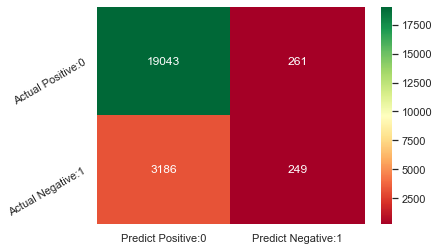

In [65]:
# visualize confusion matrix with seaborn heatmap
CM=confusion_matrix(y_valid, y_pred)

cm_matrix = pd.DataFrame(data=CM, columns=['Predict Positive:0', 'Predict Negative:1'], index=['Actual Positive:0', 'Actual Negative:1'])
sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='RdYlGn')
plt.yticks(rotation=30)

In [66]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",round(accuracy_score(y_valid, y_pred),4))

Accuracy: 0.8484


In [67]:
# Precision score on the test data
print("Precision Score:",round(precision_score(y_valid, y_pred),4))

Precision Score: 0.4882


In [69]:
# Precision score on the test data
print("F-1 Score:",round(f1_score(y_valid, y_pred),4))

F-1 Score: 0.1262


**Feature Importance: I checked the feature importances of Random Forest model by using Gini Index. "Categ_merchant", "Categ_posEntry" and "Categ_Transac" played much more significant role than others in classifiying fraudulent cases.**

In [1128]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(18,9))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + " " +'Feature Importance',weight='bold')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

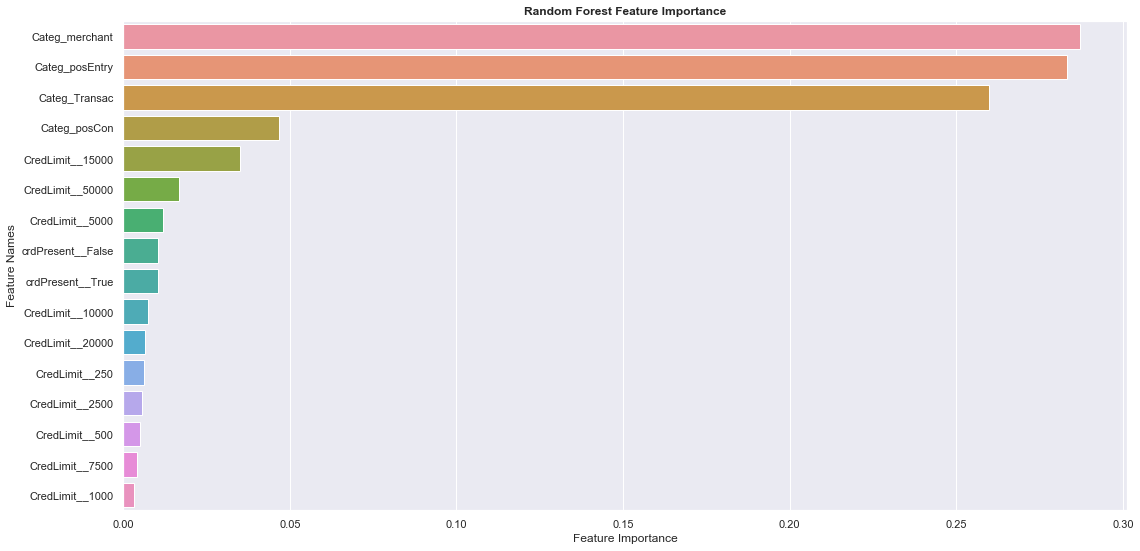

In [1129]:
plot_feature_importance(clf.feature_importances_,X_train.columns,'Random Forest')

---

# 2. Gradient Boosting

**Secondly, I executed Gradient Boosting model to classify fraud cases.**

In [70]:
# define Gradient Boosting model
clf = GradientBoostingClassifier(n_estimators=800, 
                                 learning_rate=0.01,
                                 max_depth=6, 
                                 random_state=5).fit(X_train, y_train)

In [71]:
# take predictions on the test data
predictions = clf.predict(X_valid)

(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

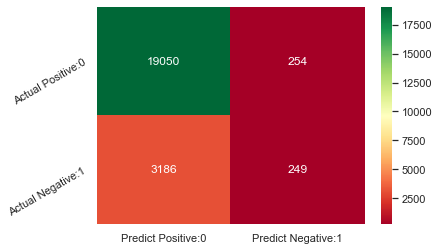

In [72]:
# visualize confusion matrix with seaborn heatmap
CM_grb=confusion_matrix(y_valid, predictions)

cm_matr = pd.DataFrame(data=CM_grb, columns=['Predict Positive:0', 'Predict Negative:1'], index=['Actual Positive:0', 'Actual Negative:1'])
sns.heatmap(cm_matr, annot=True, fmt='d', cmap='RdYlGn')
plt.yticks(rotation=30)

In [73]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",round(accuracy_score(y_valid, predictions),4))

Accuracy: 0.8487


In [74]:
# Precision Score on the test data
print("Precision Score:",round(precision_score(y_valid, predictions),4))

Precision Score: 0.495


In [75]:
# Precision Score on the test data
print("F-1 Score:",round(f1_score(y_valid, predictions),4))

F-1 Score: 0.1265


-------

# 3. Extreme Gradient Boosting with Grid Search

**I applied extreme gradient boosting with grid search tecnhique. This helped me tuning hyper-parameters such as max_depth, n_estimators and learning rate.**

In [77]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [1066]:
estimator = xgb.XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=123
)

In [1067]:
parameters=  { 'max_depth': range (5, 11,4),
    'n_estimators': range(800, 1000, 50),
    'learning_rate': [0.1, 0.01, 0.001]}

In [1071]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring='f1',
    n_jobs = 10,
    cv = 4,
    verbose=True
)

In [1074]:
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 24 candidates, totalling 96 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed: 16.2min
[Parallel(n_jobs=10)]: Done  96 out of  96 | elapsed: 51.9min finished


GridSearchCV(cv=4, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=123, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.001],
                         'max_depth': range(5, 11, 4),
                         'n_estimators': range(800, 1000, 50)},
  

In [1075]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              silent=None, subsample=1, verbosity=1)

**After performing Grid Search, I selected best estimators and applied on the dataset.**

In [78]:
xgb_cl = xgb.XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.001, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=800, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
              silent=None, subsample=1, verbosity=1)

In [79]:
#Fit the model
xgb_cl.fit(X_train,y_train)

#Predict the model
preds = xgb_cl.predict(X_valid)

(array([0.5, 1.5]), <a list of 2 Text yticklabel objects>)

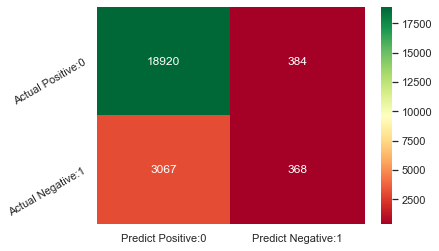

In [80]:
# visualize confusion matrix with seaborn heatmap
CM_xgb=confusion_matrix(y_valid, preds)

cm_matr = pd.DataFrame(data=CM_xgb, columns=['Predict Positive:0', 'Predict Negative:1'], index=['Actual Positive:0', 'Actual Negative:1'])
sns.heatmap(cm_matr, annot=True, fmt='d', cmap='RdYlGn')
plt.yticks(rotation=30)

In [81]:
# check precision rate score on validation data
print("Accuracy:",round(accuracy_score(y_valid, preds),4)) 

Accuracy: 0.8482


In [82]:
# check precision rate score on validation data
print("Precision Score:",round(precision_score(y_valid, preds),4)) 

Precision Score: 0.4894


In [83]:
# check precision rate score on validation data
print("F-1 Score:",round(f1_score(y_valid, preds),4)) 

F-1 Score: 0.1758


Text(0.5, 0, 'Xgboost Feature Importance')

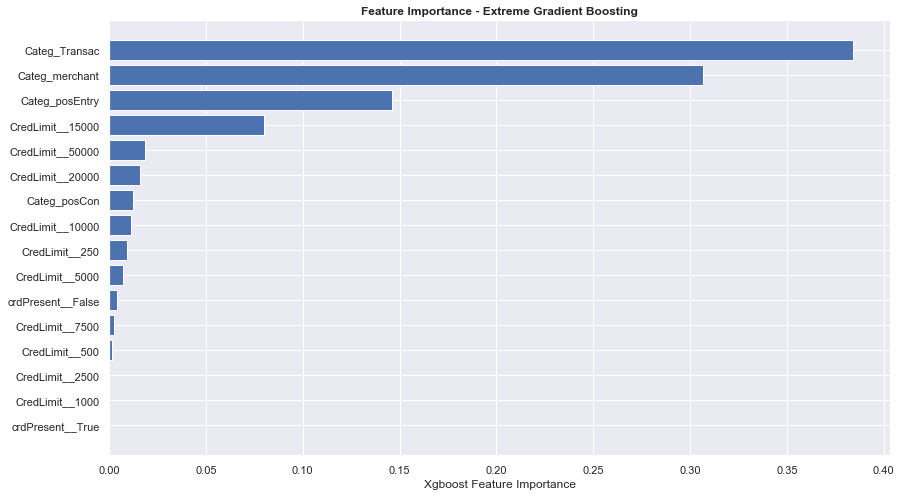

In [1148]:
plt.figure(figsize=(14,8))
plt.title('Feature Importance - Extreme Gradient Boosting',weight='bold')
sns.set()
sorted_idx = xgb_cl.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], xgb_cl.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

--------